## Constructing A Consistently Oriented Eigenbasis
	
Upon performing SVD, the sign of the basis vectors can be flipped without affecting the validity of the singular value decomposition. That means that if the SVD is performed repeatedly on a slowly evolving system, the derived eigenbasis of the system can abruptly change, from, for example, a left-handed to a right-handed coordinate system. Hence there is a need to find a way to consistently orient the basis of eigenvectors. 

Heuristic techniques can work by taking the dot product between the singular vectors derived for two separate SVDs, and flipping them whenever the dot product is negative. A more rigorous technique was derived by Damask (2019). Damask's technique relies on constructing the sequence of reflection and rotation operations necessary to transform a constituent basis into the derived eigenbasis. The gradual transformation begins with the singular vector with the largest singular value, because it has the greatest numerical certainty. 

Once consistently oriented, directional statistics can be applied to analyze the evolution of the eigensystem over different measurements. 

In general, singular vectors are only labeled by their corresponding singular value (assuming no degeneracy). Rank order changes require attaching an additional label to the eigenvectors.

Reference: 
https://arxiv.org/abs/1912.12983

### Testing the Thucyd Package

Jay's thucyd package can be used to correct sign flips in eigenbases.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import thucyd

In [312]:
### Square Matrices -- doesn't work for complex eigenvalues / eigenvectors 

def check(V,E):
    return np.matmul(np.matmul(V,E),V.T)

for i in range(100):
    N = 20
    M = np.random.randn(N,N)
    E,V = np.linalg.eig(M)

    # get real
    E = np.diag(E.real)
    V = V.real
    M = np.matmul(np.matmul(V,E),V.T)

    # orient the original matrix V
    Vor , Eor , signs , theta_matrix , sort_indices = thucyd.eigen.orient_eigenvectors(V,E)


    assert np.allclose(M,check(Vor,Eor))
    
print("Works.")

Works.


In [316]:
### SVD -- SVD always returns real eigenvalues bc A^TA is hermitian and real eigenvectors if A is real

### Flipping must be symmetric

def check_svd(U,S,V):
    return np.matmul(np.matmul(U,S),V)

for i in range(100):
    N = 3
    M = np.random.randn(N+1,N)
    U,S,Vh = np.linalg.svd(M,full_matrices=False)
    S = np.diag(S)

    assert np.all(np.isreal(S))
    assert np.all(S >= 0)
    assert np.all(np.isreal(U))
    assert np.all(np.isreal(V))
    
    Vor , Eor , signs , theta_matrix , sort_indices = thucyd.eigen.orient_eigenvectors(Vh.T,S)
    Vorh = Vor.T
    Uor = np.matmul(U,np.diag(signs))
    
    assert np.allclose(check_svd(U,S,Vh),M)
    assert np.allclose(M,check_svd(Uor,S,Vorh))
    
print("Works.")

Works.


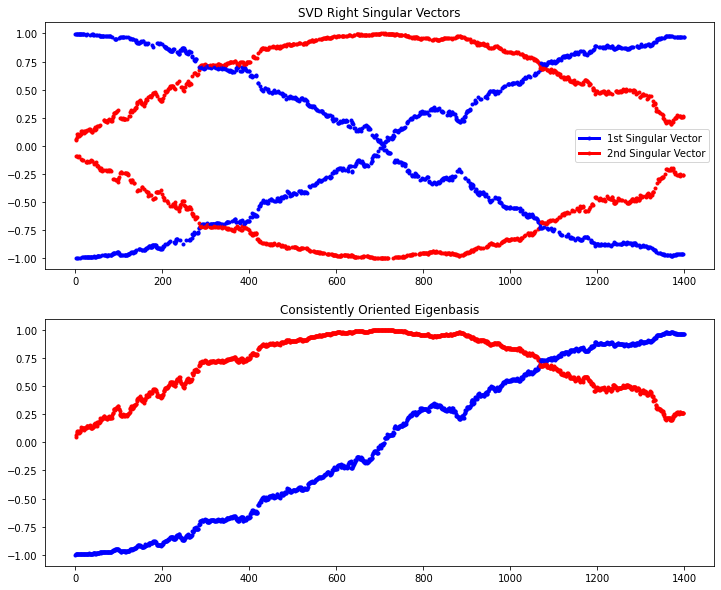

In [440]:
""" 
Tracking eigenvectors of an evolving system.

Slowly rotating in 2D
"""

def Rotation2D(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])



def rolling_window(X,size=10):
    for i in range(size,len(X)):
        yield X[i-size:i]
        

# total number of samples
N = 1500

# singular values & average
sig = np.diag([1,0.5])
mu = np.array([0,0]).T


X = []
for theta in np.linspace(-np.pi/2,np.pi/2,N):
    R = Rotation2D(theta) 
    x = np.matmul(R,np.matmul(sig,np.random.randn(2,1))).T
    X += [list(x)]
    
X = np.vstack(X)

        
        
fig = plt.figure(figsize=(12,10))
     

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

for offset,window in enumerate(rolling_window(X,size=100)):
    U,S,Vh = np.linalg.svd(window,full_matrices=False)
    
    E = np.diag(S)
    
    Vor , Eor , signs , theta_matrix , sort_indices = thucyd.eigen.orient_eigenvectors(Vh.T,E)
    Vorh = Vor.T
    Uor = np.matmul(U,np.diag(signs))
    
    assert np.allclose(window,check_svd(Uor,E,Vorh))
    
    vor1 = Vor[:,0]
    vor2 = Vor[:,1]
    
    v1 = Vh.T[:,0]
    v2 = Vh.T[:,1]
    
    ax1.plot(v1[0]+offset,v1[1],'.-',linewidth=3,color='blue')
    ax1.plot(v2[0]+offset,v2[1],'.-',linewidth=3,color='red')
    ax1.set_title('SVD Right Singular Vectors')
    ax1.legend(['1st Singular Vector','2nd Singular Vector'],fontsize=10)

    
    ax2.plot(vor1[0]+offset,vor1[1],'.-',linewidth=3,color='blue')
    ax2.plot(vor2[0]+offset,vor2[1],'.-',linewidth=3,color='red')
    ax2.set_title('Consistently Oriented Eigenbasis')

    
plt.savefig('./img/svd_consistently_oriented.png')